In [1]:
import os
import sys
import inspect
import datetime
from time import time
from importlib import reload  
import pandas as pd
import numpy as np
import tables
import h5py
from joblib import load, dump
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json

import HpTrainingFrame
from HpMLWeightTransformer import MultiSBWeightsScaler, WeightsMultiplier
from HpMLMTL import HpMTLBackgroundAugmenter, HpMTLBackgroundRandomizer
from HpMLUtils import FeatureDivider,variance
from HpMLFeatureNormalisation import WeightedStandardScaler
import HpKerasUtils
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from sklearn.metrics import roc_auc_score, roc_curve

In [15]:
inspect.getfile(HpMLMTL)

'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/HpMLMTL.py'

In [17]:
reload(HpMLMTL)

<module 'HpMLMTL' from '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/HpMLMTL.py'>

In [2]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names=["nJets","nBTags_70","pT_jet1","Mbb_MindR_70","pT_jet5","H1_all","dRbb_avg_70","dRlepbb_MindR_70","Muu_MindR_70","HT_jets","Mbb_MaxPt_70","Mbb_MaxM_70","Mjjj_MaxPt","Centrality_all"]
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

# Functions definition

In this section two functions will be defined, one for preparing the data for training and another one for the training itself.

In [3]:
def label_discr (row):
    ''' Function to filter hpdiscriminant value by mass'''
    if(row.hpmass<0): 
        return row['HpDiscriminant_'+str(-int(row.hpmass))]
    else: 
        return row['HpDiscriminant_'+str(int(row.hpmass))]

def PrepareMassParametrised(df, feature_names, hpmass='multi', region="INC_ge6jge4b", steps_names=['msb','scl','rnd','fd','wss'], onediscr=True):
    """Prepares data for training. It can be selected which modifications will be done to the data:
        msb: MultiSBWeightsScaler
        scl: WeightsMultiplayer
        aug: HpMTLBackgroundAugmenter
        rnd: HpMTLBackgroundRandomizer
        fd: FeatureDivider
        wss: WeightStandardScaler
        Returns 9 data frames corresponding to train, test and data evaluation"""
    
    #WeightsMultiplier scale for multiple mass NN
    scales={
      200:16.,
      225:8.,
      250:8.,
      275:8.,
      300:16./3.,
      350:4.,
      400:8./3.,
      500:2.,
      600:2.,
      700:2.,
      800:2.,
      900:2.,
      1000:4./3.,
      1200:1.,
      1400:1.,
      1600:1.2,
      1800:1.5,
      2000:4.,
    }
    
    discr = ['HpDiscriminant_200','HpDiscriminant_225','HpDiscriminant_250','HpDiscriminant_275','HpDiscriminant_300','HpDiscriminant_350','HpDiscriminant_400','HpDiscriminant_500','HpDiscriminant_600','HpDiscriminant_700','HpDiscriminant_800','HpDiscriminant_900','HpDiscriminant_1000','HpDiscriminant_1200','HpDiscriminant_1400','HpDiscriminant_1600','HpDiscriminant_1800','HpDiscriminant_2000']
    
    if onediscr==True:
        htf = HpTrainingFrame.HpTrainingFrame(df,feature_names + discr)
    else:
        htf = HpTrainingFrame.HpTrainingFrame(df,feature_names)
    msb = MultiSBWeightsScaler(backgroundclass=-1)
    scl = WeightsMultiplier(scales=scales,backgroundclass=-1)
    aug = HpMTLBackgroundAugmenter(backgroundclass=-1)
    rnd = HpMTLBackgroundRandomizer(backgroundclass=-1)
    fd = FeatureDivider("hpmass")
    wss = WeightedStandardScaler()
        
    steps=[(msb,"msb"),(scl,"scl"),(aug,"aug"),(rnd,"rnd"),(fd,"fd"),(wss,"wss")]
        
    #Divide data in three data frames, one for data, second for labels and third for weights
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=hpmass,region=region,addMass=True)
    y_train = X_train.hpmass.copy()
    y_test = X_test.hpmass.copy()
      
    #Processing data and preparing it for training. Only chosen modifications will be done
    for hp_class, class_name in steps:
        if class_name in steps_names:

            hp_class.fit(X_train,X_train.hpmass, sample_weight=w_train)
            X_train, y_train, w_train = hp_class.transform(X_train,y_train, sample_weight=w_train)
            X_test, y_test, w_test = hp_class.transform(X_test,y_test, sample_weight=w_test)
            
            if class_name=='rnd' and onediscr==True:
                #Remove the discriminant
                for imass in list(X_train.hpmass.unique()):
                    X_train.loc[X_train.hpmass == imass,'HpDiscriminant'] = X_train[X_train.hpmass == imass]['HpDiscriminant_'+str(imass)]
                    X_test.loc[X_test.hpmass == imass,'HpDiscriminant'] = X_test[X_test.hpmass == imass]['HpDiscriminant_'+str(imass)]
#                X_train['HpDiscriminant'] = X_train.apply(lambda row: label_discr(row), axis=1)
#                X_test['HpDiscriminant'] = X_test.apply(lambda row: label_discr(row), axis=1)
                
                X_train = X_train.drop(columns=discr)
                X_test = X_test.drop(columns=discr)            
                #Move the mass column to the last
                cols = list(X_train.columns)
                cols[-2:] = cols[:-3:-1]
                X_train = X_train[cols]
                X_test = X_test[cols]

            #Printing background and signal integral. Just to clarify how weights change in every process
            print(class_name + ":")
            print("Background integral:",w_train.values[y_train<0].sum(),"\nSignal integral:",w_train.values[y_train>0].sum(),'\n')
            
                
    y_train=(y_train>0)
    y_test=(y_test>0)
    
    if 'wss' in steps_names: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(wss.mean_,wss.scale_)]
    else: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(None,None)]

In [4]:
def getCallbacks(model):
    """ Standard callbacks for Keras Early stopping and checkpoint"""
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath='model_nn_'+str(model.configuration)+"_dropout"+str(model.dropout)+"_l2threshold"+str(model.l2threshold)+".hdf5",
                        monitor='val_loss',
                        save_best_only=True)  
    ]


def training(training_data,test_data,configuration,dropout,epochs,patience,batch_size,trainlabel,region):
    """Training function"""
    
    #Keeping track of when the training started
    training_start = int(time())
    start_hour = datetime.datetime.now().strftime("%H:%M:%S")
    
    #Standard feedforward model
    modelNN = HpKerasUtils.HpFeedForwardModel(configuration,dropout=dropout, verbose=True, input_dim=X_train.shape[1])
    resultNN = modelNN.train(training_data, test_data, patience=patience , epochs=epochs, callbacks=getCallbacks(modelNN), batch_size=batch_size)
    
    #Keeping track of when the training finished. Getting the training time
    training_finish = int(time())
    finish_hour = datetime.datetime.now().strftime("%H:%M:%S")
    dif_time = training_finish-training_start
    print('Start hour:'+start_hour+'\n'+'Finish hour:'+finish_hour+'\n'+'Training time:'+str(datetime.timedelta(seconds=dif_time)))
    
    #Saving raw NN model
    #dump(modelNN,'NN_sergio_results/massparameterisedNN_'+ region +'_'+ trainlabel + '.joblib')
    
    #Printing training results and plotting binary accuracy and loss
    print(resultNN)
    modelNN.plotTrainingValidation()
    
    return modelNN

In [18]:
def ROC_Score_plot(modelNN,X,y,w,path,reg,plotlabel,do_ROC=True,do_Score=True,hpmass=None):
    """Function that plots ROC curve and NN socore for the test data
       on Matplotlib"""
    
    #Getting the data we want to plot
    y_pred = modelNN.model.predict(X.values).ravel()
    roc_auc = roc_auc_score(y,y_pred,sample_weight=w)
    false_pr, true_pr, thresholds = roc_curve(y, y_pred, sample_weight = w)
    
    if do_ROC==True:
        #Plotting ROC
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.plot(false_pr,true_pr, ls='-', c="blue", linewidth=1.3, label="ROC (area = {:.5f})".format(roc_auc))
        plt.plot([0.,1.],[0.,1.], ls='--', c="gray", linewidth=1.3, label="Luck")

        plt.xlabel("False Positive Rate", ha="right",x=1, fontsize=10.3, labelpad=10)
        plt.ylabel("True Positive Rate",ha= "right",y=1, fontsize=11, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(-.05, 1.05)

        plt.legend(loc="best", frameon=True, prop=fm.FontProperties(fname=fpath,size=11))
        
        if hpmass==None: plt.savefig(path + '/roc_curve_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/roc_curve_' + reg + '_' + str(hpmass) + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        plt.show
    
    if do_Score==True:
        #Plotting Score
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.hist(y_pred[y<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=1.3, density=True, label="Background")
        plt.hist(y_pred[y>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=1.3, density=True, label="H$^+$mass={} GeV".format(hpmass)\
                 if hpmass!= None else 'Signal')

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=10.3, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=11))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.15,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center',\
                 transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=11))

        if hpmass==None: plt.savefig(path + '/NN_Score_' + reg + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/NN_Score_' + reg + '_' + str(hpmass) + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        plt.show
        
    return roc_auc

        
def AUCvsHpmass(rocs,mass,reg,path,plotlabel):
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(mass,rocs, ls='-', c="blue", marker='o', linewidth=1.3)
    plt.plot([0.,2400.],[1.,1.], ls='--', c="gray", linewidth=1.3)

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=10.3, labelpad=10)
    plt.ylabel("AUC",ha= "right",y=1, fontsize=11, labelpad=10)

    plt.minorticks_on()
    plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
    plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

    plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

    plt.xlim(0,2200)
    plt.ylim(0.6, 1.02)

    plt.savefig(path + '/aucvsmass_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

def relativeAUC(aucs,auc_file_name,reg,path,plotlabel):
    
    with open(auc_file_name,'r') as inputFile:
        data = json.load(inputFile)
        mass = data['Hp mass']
        old_auc = data['AUC']
        
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(mass,np.abs(aucs-old_auc)/aucs, c="blue", marker='o', ls='None')

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=10.3, labelpad=10)
    plt.ylabel("Relative AUC difference",ha= "right",y=1, fontsize=11, labelpad=10)

    plt.minorticks_on()
    plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
    plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

    plt.xlim(0,2200)
#    plt.ylim(-0.1e-3, 4.5e-3)

    plt.savefig(path + '/relativeauc_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

# Runner

## Old pandas

In [6]:
df_mc = pd.read_hdf('/nfs/at3/scratch/salvador/HplusML/HDFWriter/R21pandas_psJul/pandas_INC_ge6jge4b_R21.h5')
df_mc = df_mc[(df_mc.process!='ttb_PowH7')&(df_mc.process!='ttc_PowH7')&(df_mc.process!='ttlight_PowH7')&(df_mc.process!='ttb_aMCNloP8')&(df_mc.process!='ttc_aMCNloP8')&(df_mc.process!='Hp1001')&\
             (df_mc.process!='ttlight_aMCNloP8')&(df_mc.process!='tH_new')&(df_mc.weight!=0)&(df_mc.hpmass!=2500)&(df_mc.hpmass!=3000)]
df_mc

,index,HpDiscriminant_900,HpDiscriminant_700,HpNNv3_900,eventNumber,Mbb_MaxPt_70,HpNNv3_300,nBTags_70,HpNNv3_275,HpDiscriminant_1400,...,HT_jets,HpDiscriminant_275,weight,ReWeighting,process,group,region,pT_jet1,hpmass,year
0,0,0.048143,0.087838,0.089174,53350789,231522.750000,0.446897,4,0.443312,0.019111,...,6.101899e+05,0.628027,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,201638.328125,-1,mc16a
1,1,0.045471,0.091250,0.010085,2954219,154286.218750,0.670696,4,0.725951,0.015989,...,4.444709e+05,0.677458,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,115786.953125,-1,mc16a
2,2,0.047972,0.060952,0.060524,9761000,112936.320312,0.118918,4,0.134655,0.035684,...,4.111982e+05,0.016884,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,139232.484375,-1,mc16a
3,3,0.018389,0.033590,0.004131,18140181,29057.541016,0.448475,4,0.502207,0.006317,...,3.534873e+05,0.621517,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,88882.429688,-1,mc16a
4,4,0.034663,0.066523,0.005803,12088318,87846.101562,0.265797,4,0.283293,0.017893,...,3.107152e+05,0.432156,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,71250.578125,-1,mc16a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199826,22426,0.649086,0.751861,0.618047,1274403,251118.109375,0.048320,5,0.024571,0.316793,...,1.525044e+06,0.107520,0.000009,1.000000,Hp2000,Hp2000,INC_ge6jge4b,358053.750000,2000,mc16e
2199827,22427,0.824714,0.948107,0.939990,1273648,507118.312500,0.140495,4,0.094456,0.815370,...,1.108569e+06,0.374193,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,336601.062500,2000,mc16e
2199828,22428,0.208218,0.200383,0.656458,1274024,216511.296875,0.192603,4,0.153756,0.310382,...,1.047438e+06,0.018333,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,402831.343750,2000,mc16e
2199829,22429,0.547869,0.260687,0.625438,1273536,220395.609375,0.233856,4,0.264953,0.401191,...,1.636550e+06,0.185814,0.000003,1.000000,Hp2000,Hp2000,INC_ge6jge4b,606258.812500,2000,mc16e


In [7]:
data = PrepareMassParametrised(df_mc, feature_names)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit=data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

In [21]:
X_train.hpmass[y_train == False].unique()

array([-1.0220589 , -0.98505746, -0.24502852,  1.53104092, -0.68904588,
        0.6430062 , -0.09702274, -0.91105456,  0.93901777, -1.13306324,
        0.05098305, -0.5410401 , -0.39303431, -1.0960618 , -1.05906035,
        1.23502935,  0.34699463, -0.83705167])

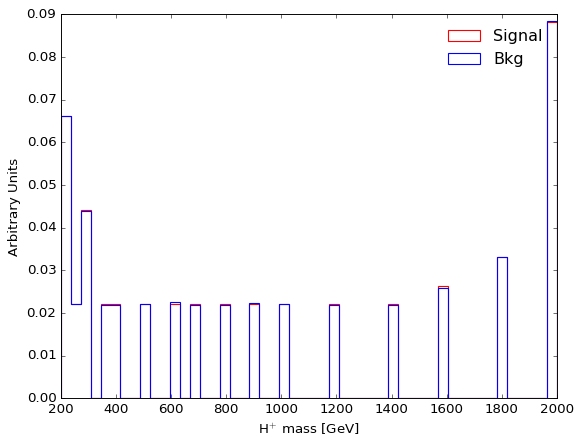

In [40]:
plt.hist(X_train[y_train==True].hpmass,weights=w_train[y_train==True],bins=50,range=[200,2000], histtype="step", fc=(1.,0.,0.,0.18),ec="red",label="Signal",density=False)
plt.hist(X_train[y_train==False].hpmass,weights=w_train[y_train==False],bins=50,range=[200,2000], histtype="step", fc=(0.,0.,1.,0.18),ec="blue",label="Bkg",density=False)
plt.ylabel('Arbitrary Units')
plt.xlabel("H$^{+}$ mass [GeV]")
plt.legend(loc="best", frameon=False)
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1920      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 104s 5ms/step - loss: 4.0589e-07 - binary_accuracy: 0.7315 

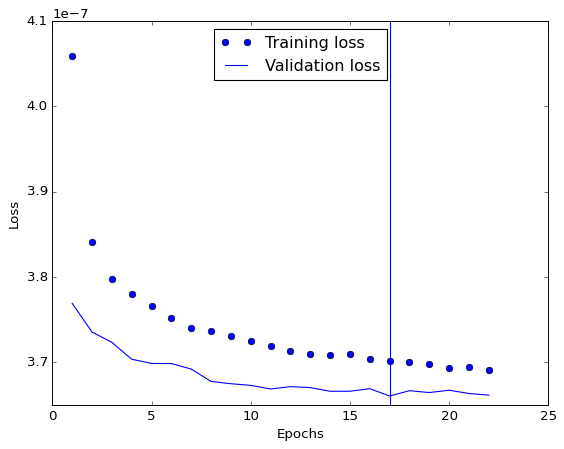

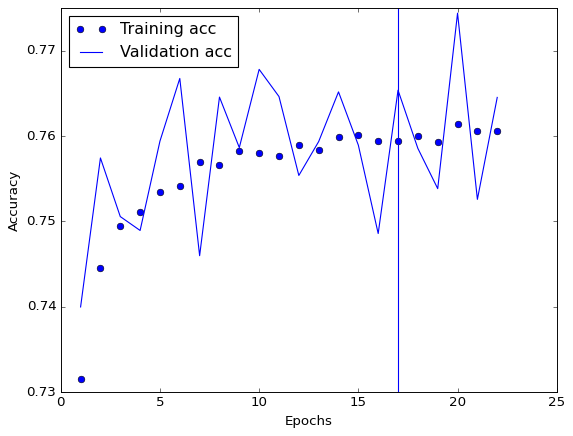

In [22]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'actual_training',region)

0.8946394007609328

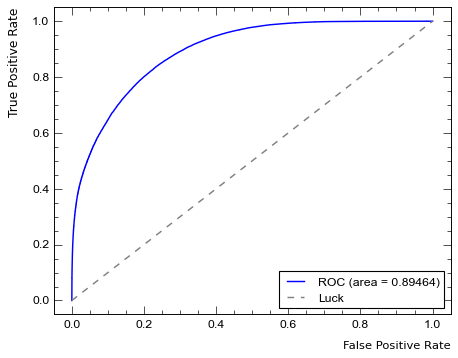

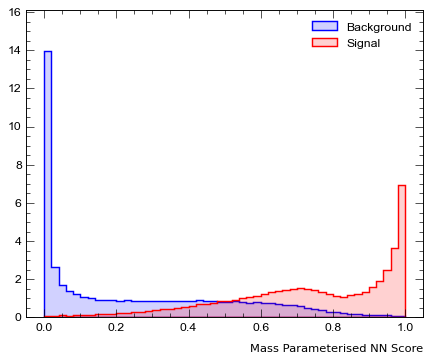

In [23]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas',region,'old_pandas')

(977067, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(978810, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980083, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980617, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981324, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980383, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980821, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980204, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981081, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981012, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

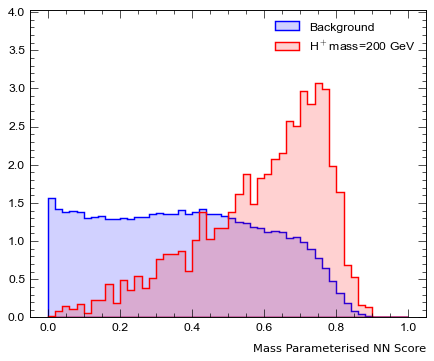

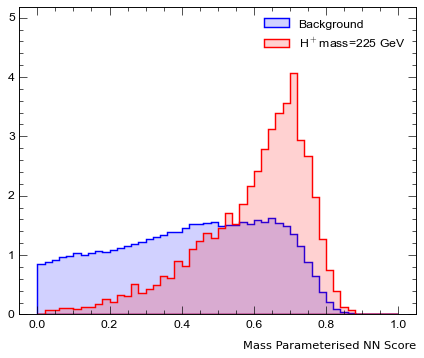

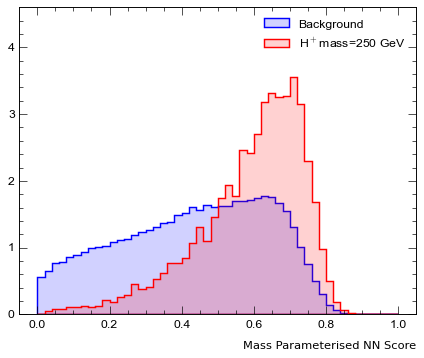

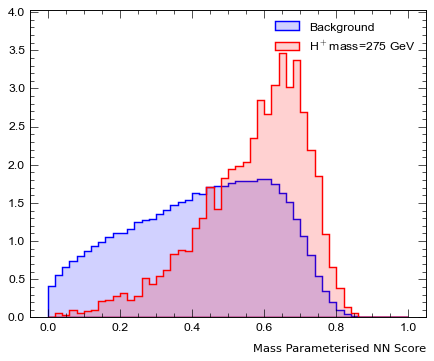

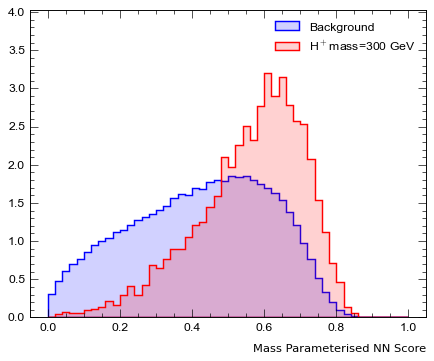

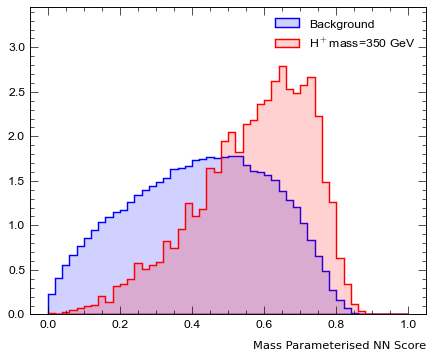

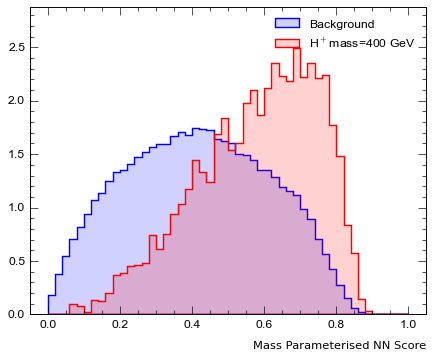

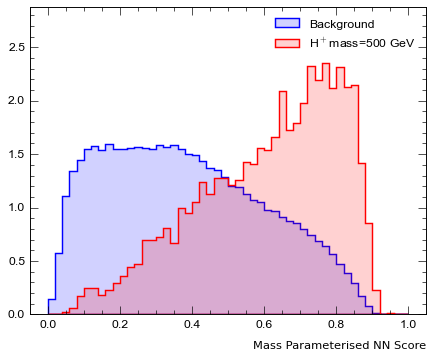

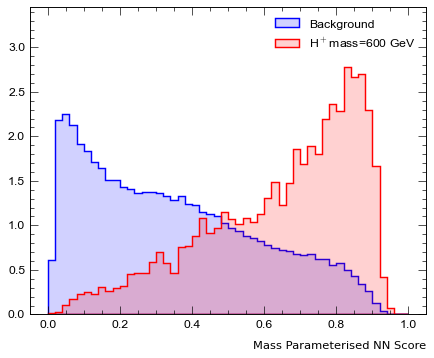

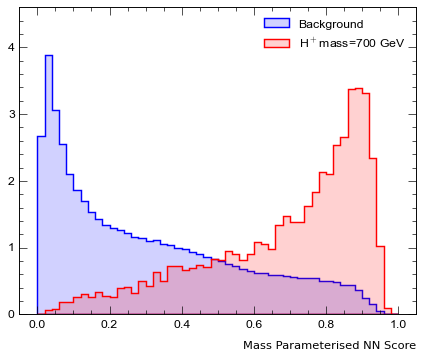

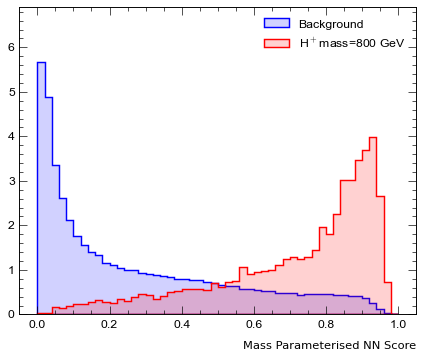

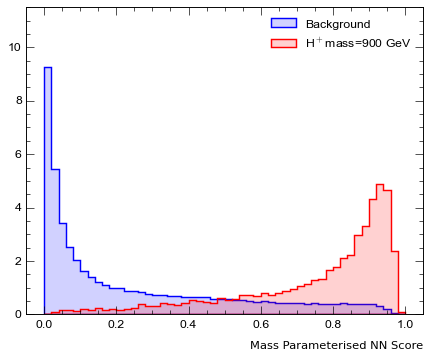

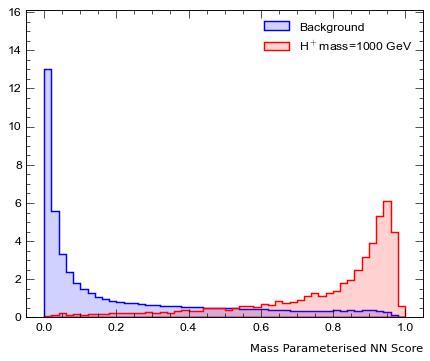

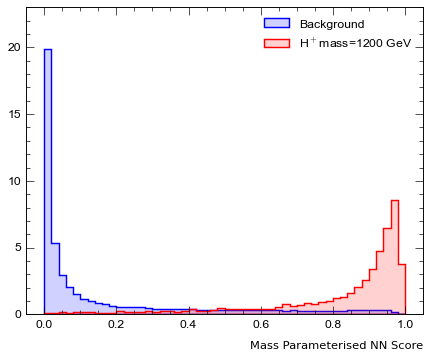

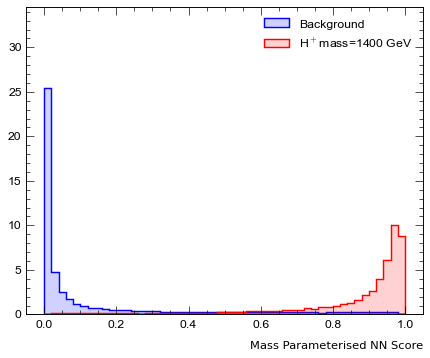

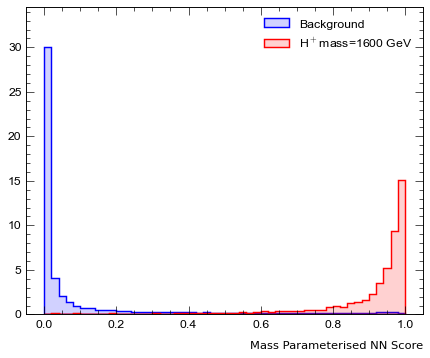

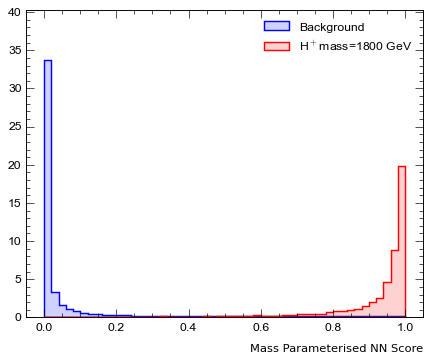

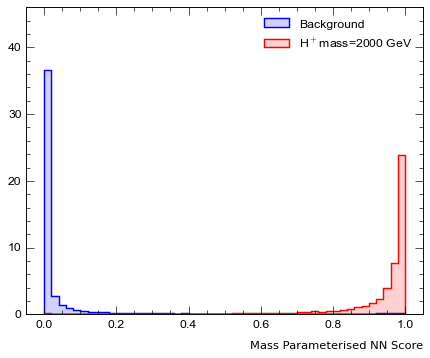

In [46]:
auc_everymass=[]

for mass in list(df_mc.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_mc,feature_names + ['HpDiscriminant_'+str(mass)])
        fd = FeatureDivider("hpmass")
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas',region,'old_pandas',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_actual_training.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

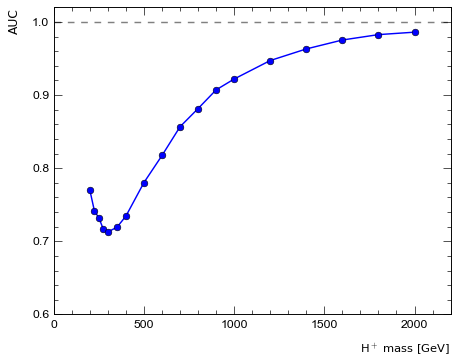

In [57]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas','old_pandas')

In [48]:
print(auc_everymass)#old pandas

[[2.00000000e+02 7.69841950e-01]
 [2.25000000e+02 7.41760167e-01]
 [2.50000000e+02 7.31877150e-01]
 [2.75000000e+02 7.16505209e-01]
 [3.00000000e+02 7.13069302e-01]
 [3.50000000e+02 7.19203207e-01]
 [4.00000000e+02 7.34607918e-01]
 [5.00000000e+02 7.80462162e-01]
 [6.00000000e+02 8.17426732e-01]
 [7.00000000e+02 8.56715006e-01]
 [8.00000000e+02 8.81563498e-01]
 [9.00000000e+02 9.07130495e-01]
 [1.00000000e+03 9.21968087e-01]
 [1.20000000e+03 9.47224459e-01]
 [1.40000000e+03 9.63076449e-01]
 [1.60000000e+03 9.75279880e-01]
 [1.80000000e+03 9.82647699e-01]
 [2.00000000e+03 9.85995000e-01]]


At this point, we will try to get the same results with the new pandas.

## New pandas

In [6]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new

,index,dRlepbb_MindR_70,jet_eta,HpDiscriminant_275,HpNNv3_350,HpNNv3_600,HpDiscriminant_225,mu_eta,Muu_MindR_70,Mbb_MaxM_70,...,Centrality_all,HpNNv3_250,weight,ReWeighting,process,group,region,tagWeightBin_MV2c10_Continuous,hpmass,year
0,0,1.632954,"[-0.61083865, -0.38421518, 1.0957781, 0.209408...",0.628027,0.464503,0.458725,0.473889,[0.66914076],168296.703125,2.315228e+05,...,0.739273,0.436460,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,"[1, 4, 5, 4, 2, 4]",-1,mc16a
1,1,2.318960,"[-0.6561383, -0.13251838, -0.52890044, -0.1273...",0.677458,0.695016,0.305937,0.316257,[],57218.773438,2.001623e+05,...,0.852112,0.681223,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 5, 4, 4, 1, 1]",-1,mc16a
2,2,0.870068,"[2.381791, -1.3918624, 1.8041257, -1.0344955, ...",0.016884,0.098823,0.099795,0.092083,[-0.25464767],110607.484375,3.339375e+05,...,0.362028,0.191971,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 1, 5, 4]",-1,mc16a
3,3,3.142407,"[0.9403318, 1.4658026, -0.07202754, 0.48571306...",0.621517,0.356497,0.042438,0.664618,[],65231.687500,1.864174e+05,...,0.654665,0.563828,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 5, 4, 1]",-1,mc16a
4,4,2.089809,"[1.0356635, 2.0446057, -2.070395, 0.088136375,...",0.432156,0.172446,0.021674,0.574934,[1.4766937],448008.250000,1.308857e+05,...,0.388816,0.330892,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 1, 5, 4, 5]",-1,mc16a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199826,22426,1.194283,"[-1.0890584, 0.63075817, 1.0227456, -0.4316607...",0.107520,0.083734,0.229890,0.034687,[0.18610953],59560.648438,3.882827e+05,...,0.706170,0.022205,0.000009,1.000000,Hp2000,Hp2000,INC_ge6jge4b,"[1, 4, 5, 1, 1, 4]",2000,mc16e
2199827,22427,0.660811,"[-1.8786281, -1.1616327, -1.0029376, 1.2959664...",0.374193,0.261849,0.908525,0.214096,[],47828.660156,7.591045e+05,...,0.415161,0.057682,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,"[1, 4, 4, 5, 1, 1]",2000,mc16e
2199828,22428,3.077740,"[1.0732831, -0.5743674, -0.75196385, -1.471726...",0.018333,0.242374,0.459658,0.010409,[-1.6413442],216598.921875,8.158399e+05,...,0.546458,0.109873,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,"[4, 1, 1, 5, 1, 4]",2000,mc16e
2199829,22429,3.017595,"[-0.54140514, 0.7016213, 1.4506986, -1.2788231...",0.185814,0.264353,0.378092,0.125298,[0.36472446],63323.738281,1.276710e+06,...,0.574709,0.282088,0.000003,1.000000,Hp2000,Hp2000,INC_ge6jge4b,"[5, 5, 5, 4, 1, 1]",2000,mc16e


In [7]:
feature_names = ["nJets","nBTags_70","jet_pt1","Mbb_MindR_70","pT_jet5","H1_all","dRbb_avg_70","dRlepbb_MindR_70","Muu_MindR_70","HT_jets","Mbb_MaxPt_70","Mbb_MaxM_70","Mjjj_MaxPt","Centrality_all"]

data = PrepareMassParametrised(df_new, feature_names)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit=data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 115s 5ms/step - loss: 4.0425e-07 - binary_accuracy: 0.7338 - 

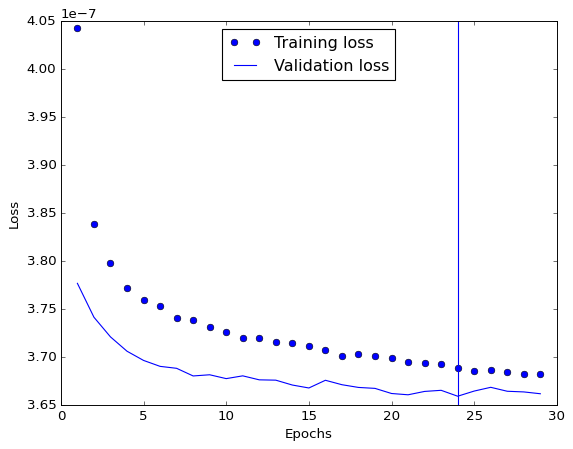

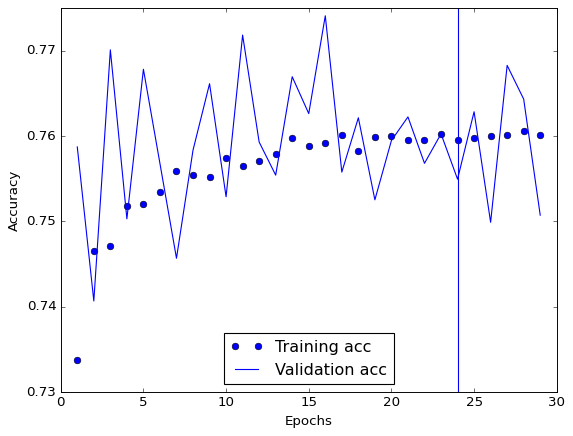

In [8]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'actual_training_vecpandas',region)

0.8947468780397391

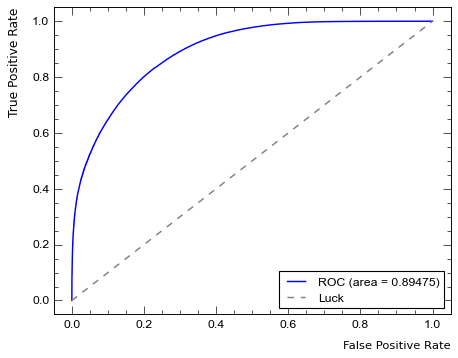

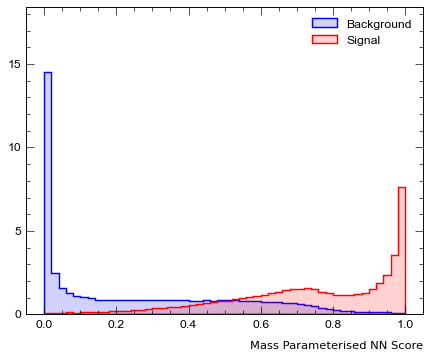

In [9]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/vec_pandas',region,'vec_pandas')

(977067, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(978810, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980083, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980617, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981324, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980383, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980821, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(980204, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981081, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
(981012, 29) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

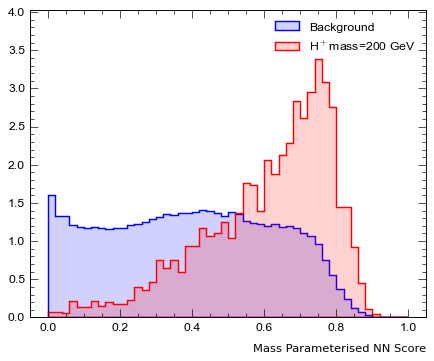

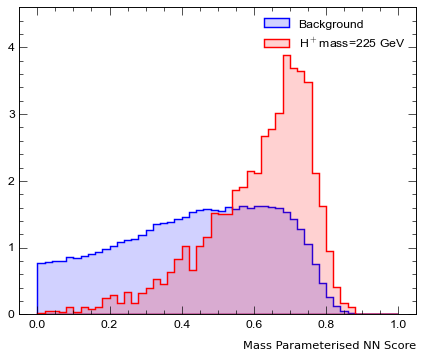

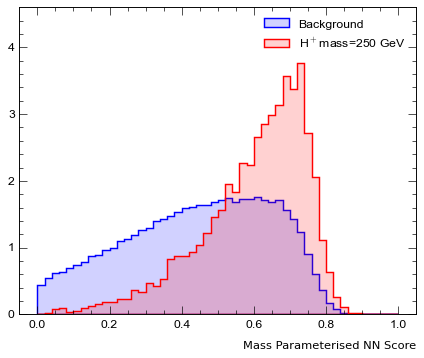

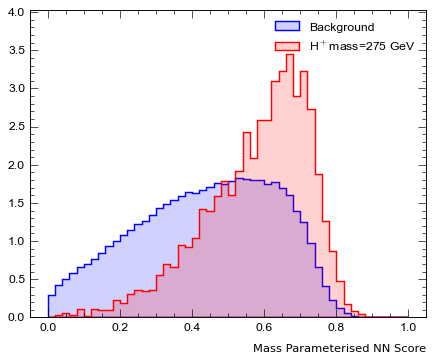

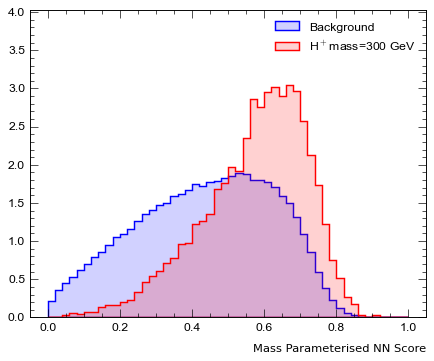

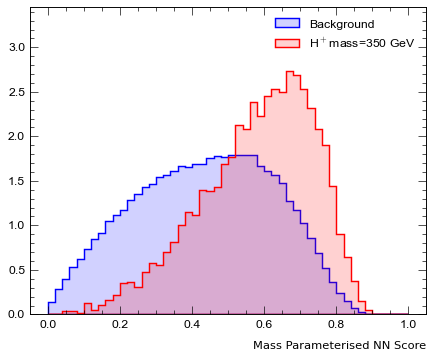

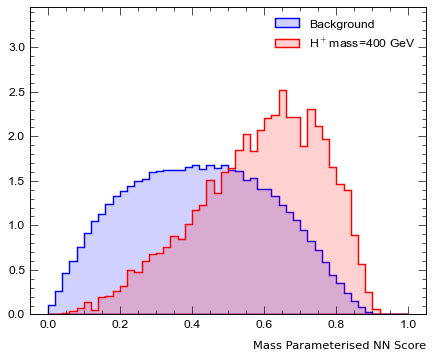

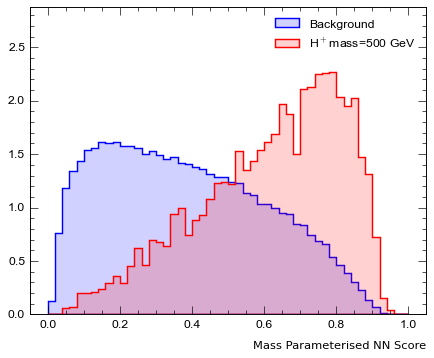

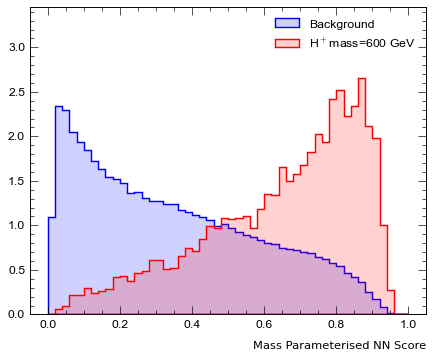

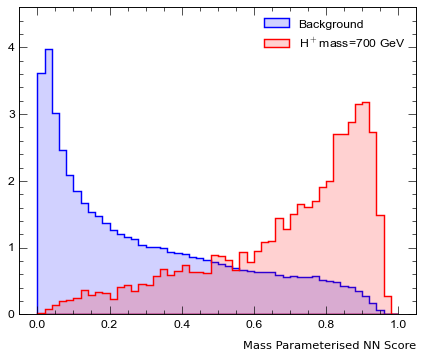

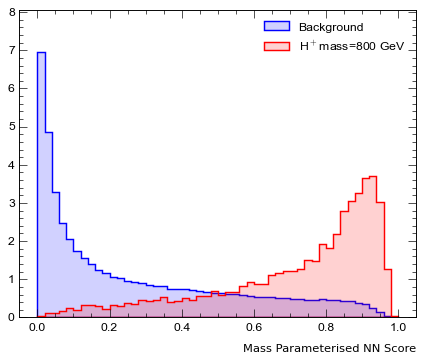

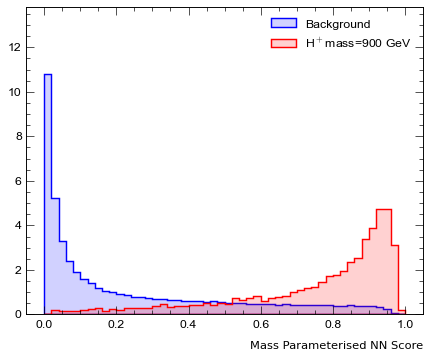

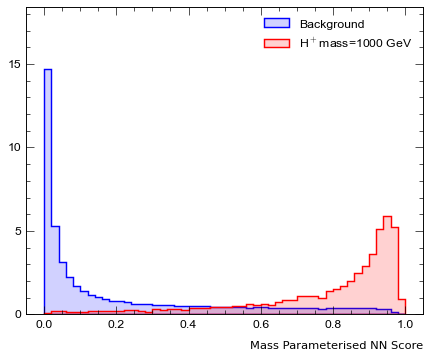

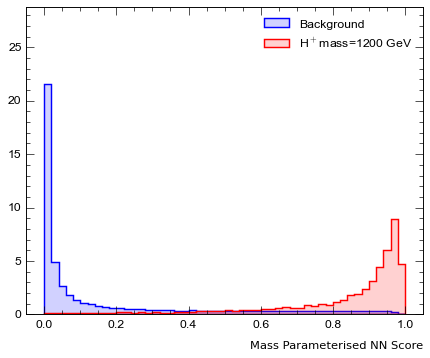

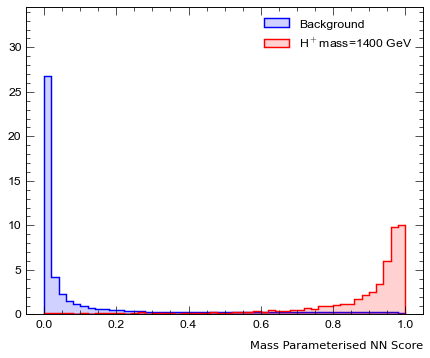

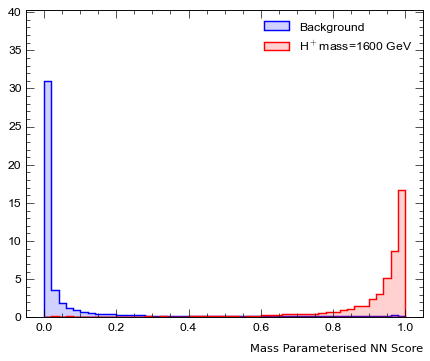

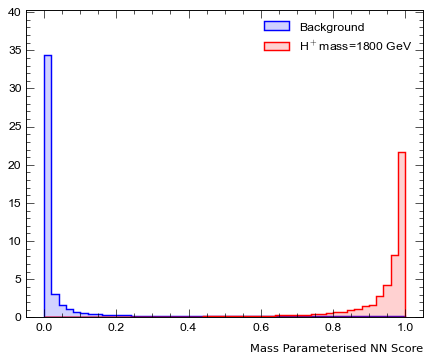

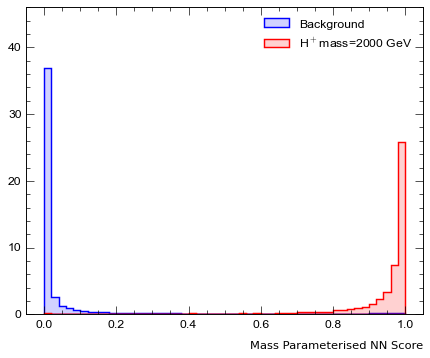

In [10]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        fd = FeatureDivider("hpmass")
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/vec_pandas',region,'vec_pandas',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

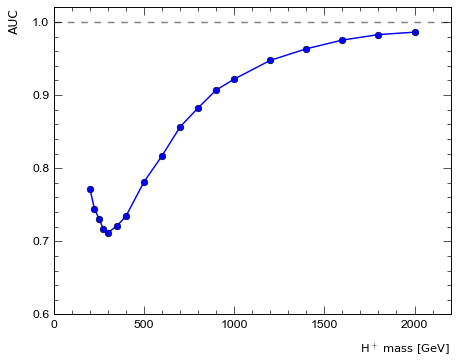

In [11]:
auc_everymass=np.array(auc_everymass)
AUCvsHpmass(auc_everymass[:,1],auc_everymass[:,0],region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/vec_pandas','vec_pandas')

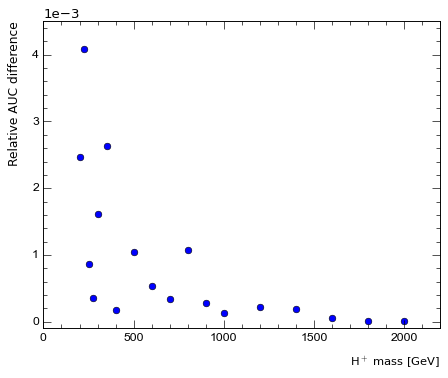

In [24]:
relativeAUC(auc_everymass[:,1],'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/vec_pandas','')

In [13]:
print(auc_everymass)

[[2.00000000e+02 7.71751493e-01]
 [2.25000000e+02 7.44802202e-01]
 [2.50000000e+02 7.31239886e-01]
 [2.75000000e+02 7.16758809e-01]
 [3.00000000e+02 7.11917633e-01]
 [3.50000000e+02 7.21100547e-01]
 [4.00000000e+02 7.34478698e-01]
 [5.00000000e+02 7.81284420e-01]
 [6.00000000e+02 8.16994439e-01]
 [7.00000000e+02 8.56422790e-01]
 [8.00000000e+02 8.82507040e-01]
 [9.00000000e+02 9.06873707e-01]
 [1.00000000e+03 9.21845847e-01]
 [1.20000000e+03 9.47434439e-01]
 [1.40000000e+03 9.63260236e-01]
 [1.60000000e+03 9.75221237e-01]
 [1.80000000e+03 9.82663533e-01]
 [2.00000000e+03 9.86008822e-01]]


## No discriminant

In [6]:
df_mc = pd.read_hdf('/nfs/at3/scratch/salvador/HplusML/HDFWriter/R21pandas_psJul/pandas_INC_ge6jge4b_R21.h5')
df_mc = df_mc[(df_mc.process!='ttb_PowH7')&(df_mc.process!='ttc_PowH7')&(df_mc.process!='ttlight_PowH7')&(df_mc.process!='ttb_aMCNloP8')&(df_mc.process!='ttc_aMCNloP8')&(df_mc.process!='Hp1001')&\
             (df_mc.process!='ttlight_aMCNloP8')&(df_mc.process!='tH_new')&(df_mc.weight!=0)&(df_mc.hpmass!=2500)&(df_mc.hpmass!=3000)]
df_mc

,index,HpDiscriminant_900,HpDiscriminant_700,HpNNv3_900,eventNumber,Mbb_MaxPt_70,HpNNv3_300,nBTags_70,HpNNv3_275,HpDiscriminant_1400,...,HT_jets,HpDiscriminant_275,weight,ReWeighting,process,group,region,pT_jet1,hpmass,year
0,0,0.048143,0.087838,0.089174,53350789,231522.750000,0.446897,4,0.443312,0.019111,...,6.101899e+05,0.628027,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,201638.328125,-1,mc16a
1,1,0.045471,0.091250,0.010085,2954219,154286.218750,0.670696,4,0.725951,0.015989,...,4.444709e+05,0.677458,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,115786.953125,-1,mc16a
2,2,0.047972,0.060952,0.060524,9761000,112936.320312,0.118918,4,0.134655,0.035684,...,4.111982e+05,0.016884,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,139232.484375,-1,mc16a
3,3,0.018389,0.033590,0.004131,18140181,29057.541016,0.448475,4,0.502207,0.006317,...,3.534873e+05,0.621517,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,88882.429688,-1,mc16a
4,4,0.034663,0.066523,0.005803,12088318,87846.101562,0.265797,4,0.283293,0.017893,...,3.107152e+05,0.432156,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,71250.578125,-1,mc16a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199826,22426,0.649086,0.751861,0.618047,1274403,251118.109375,0.048320,5,0.024571,0.316793,...,1.525044e+06,0.107520,0.000009,1.000000,Hp2000,Hp2000,INC_ge6jge4b,358053.750000,2000,mc16e
2199827,22427,0.824714,0.948107,0.939990,1273648,507118.312500,0.140495,4,0.094456,0.815370,...,1.108569e+06,0.374193,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,336601.062500,2000,mc16e
2199828,22428,0.208218,0.200383,0.656458,1274024,216511.296875,0.192603,4,0.153756,0.310382,...,1.047438e+06,0.018333,-0.000010,1.000000,Hp2000,Hp2000,INC_ge6jge4b,402831.343750,2000,mc16e
2199829,22429,0.547869,0.260687,0.625438,1273536,220395.609375,0.233856,4,0.264953,0.401191,...,1.636550e+06,0.185814,0.000003,1.000000,Hp2000,Hp2000,INC_ge6jge4b,606258.812500,2000,mc16e


In [7]:
data = PrepareMassParametrised(df_mc, feature_names, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit=data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1792      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 127s 6ms/step - loss: 4.1716e-07 - binary_accuracy: 0.7241 - 

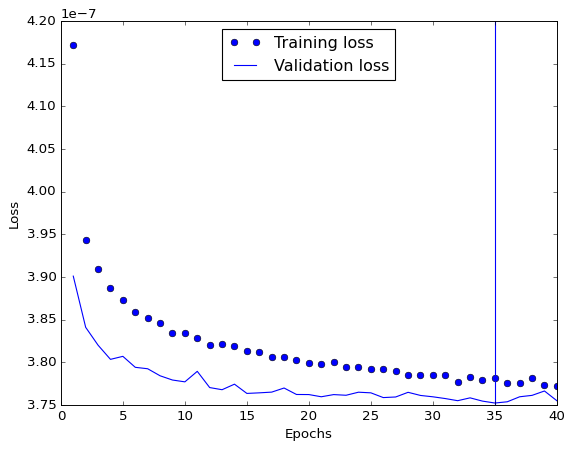

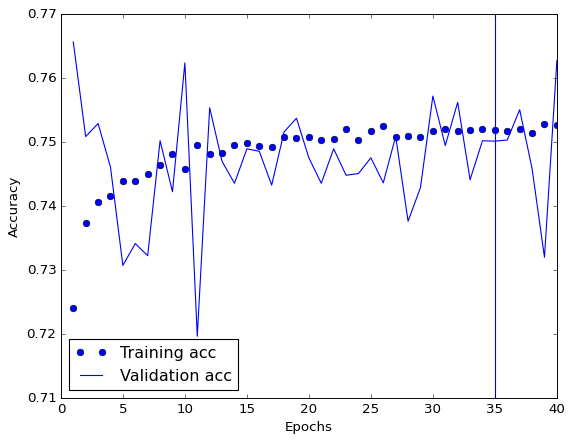

In [8]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'highlvl_nodiscr',region)

0.8880035689374653

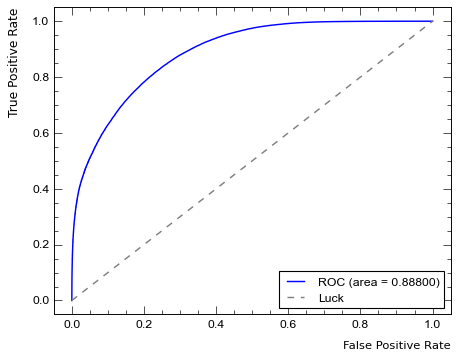

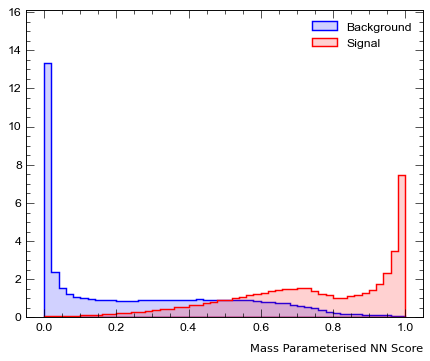

In [10]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas',region,'no_discr')

(977067, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(978810, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(980083, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(980617, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(981324, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(980383, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(980821, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(980204, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(981081, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(981012, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(981547, 27) [ 0  1  2  3  4  

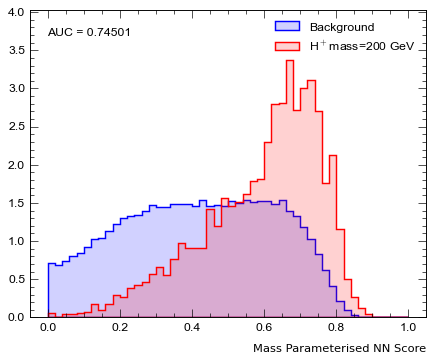

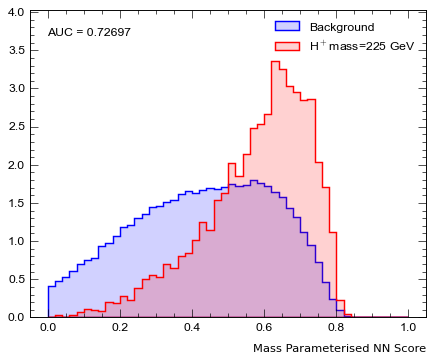

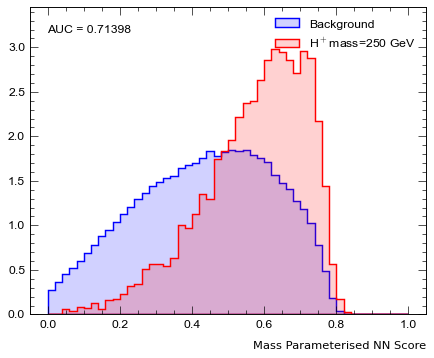

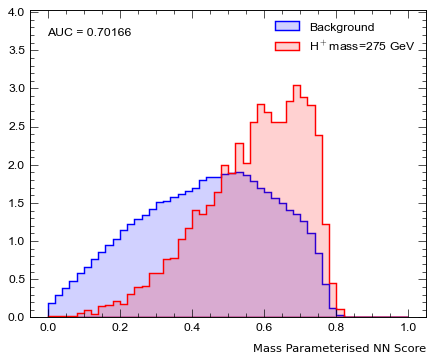

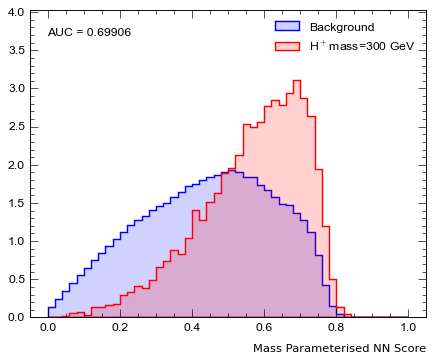

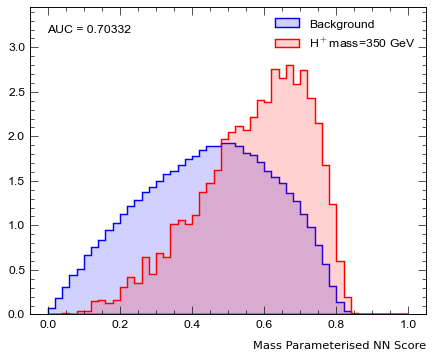

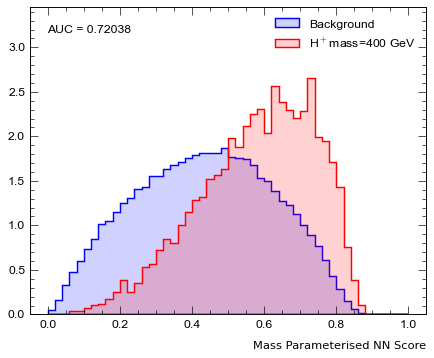

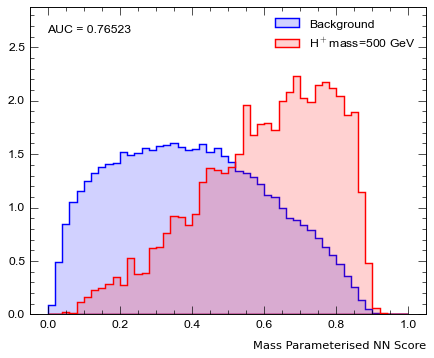

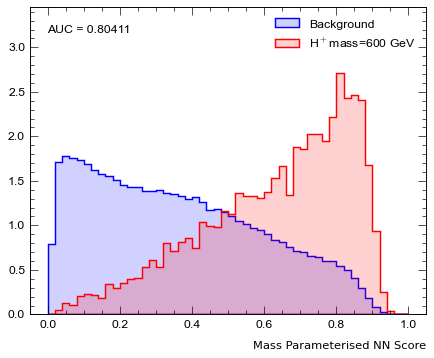

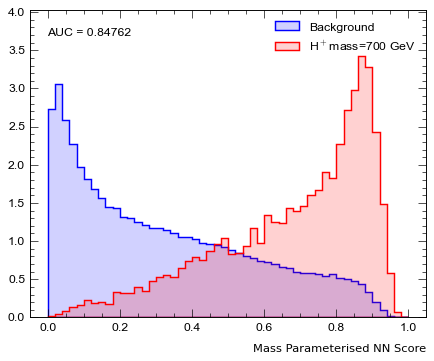

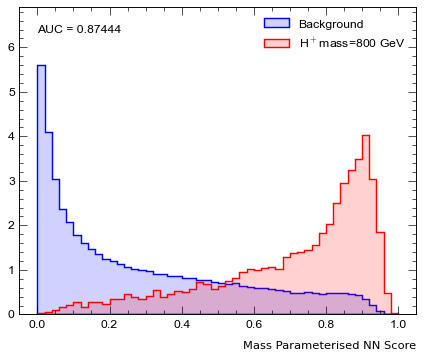

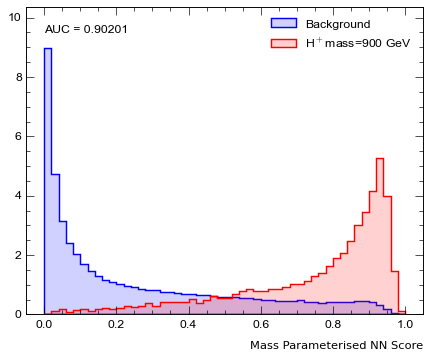

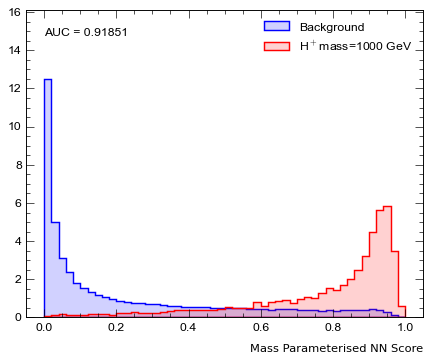

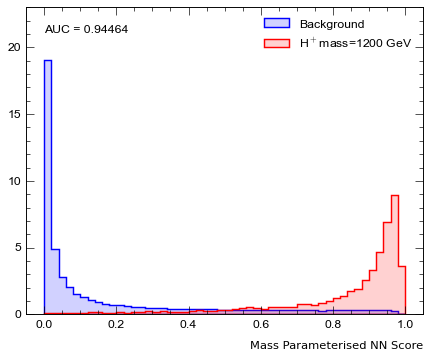

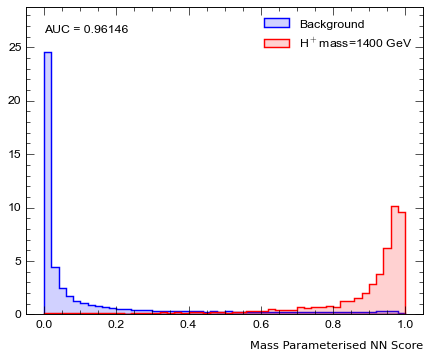

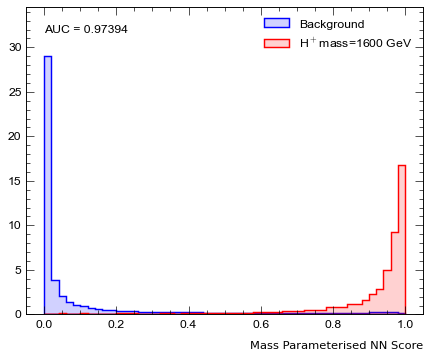

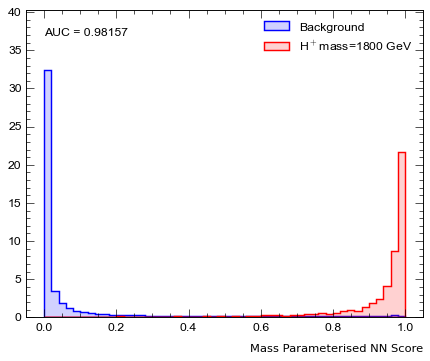

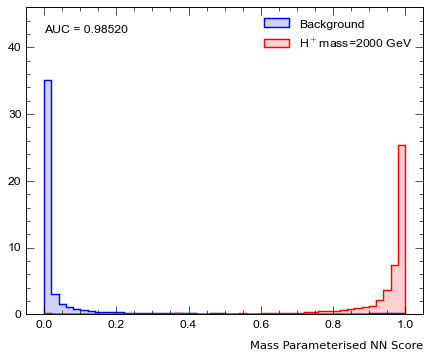

In [14]:
auc_everymass=[]

for mass in list(df_mc.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_mc,feature_names)
        fd = FeatureDivider("hpmass")
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas',region,'no_discr',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_highlvl_nodiscr.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

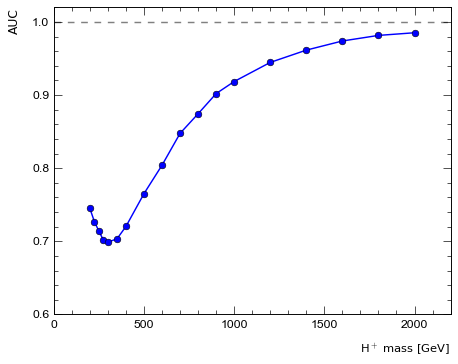

In [16]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas','highlvl_nodiscr')

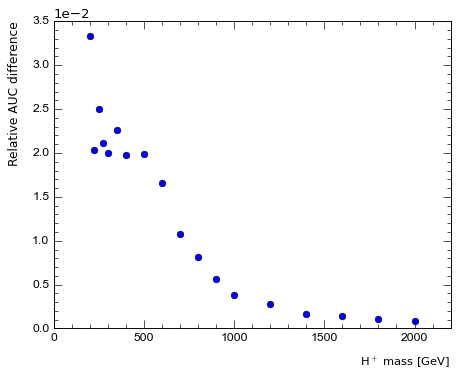

In [19]:
relativeAUC(auc_everymass[:,1],'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/actual_training/old_pandas','discr_comparison')